In [1]:
import numpy as np
from rubin_sim.scheduler.utils import empty_observation
from rubin_sim.site_models import Almanac
import matplotlib.pylab as plt
%matplotlib inline
from ddf_quick import Fast_ddf_sim

In [2]:
# Load up the pre-computed info
ddf_precompute = np.load('ddf_grid.npz')

Text(0, 0.5, '5 sigma depth in g (mags)')

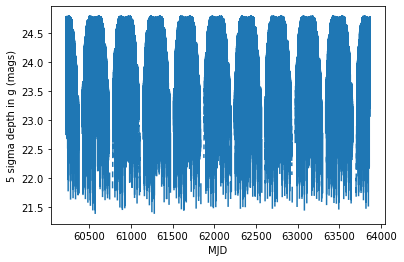

In [3]:
plt.plot(ddf_precompute['ddf_grid']['mjd'], ddf_precompute['ddf_grid']['DD:ELAISS1_m5_g'])
plt.xlabel('MJD')
plt.ylabel('5 sigma depth in g (mags)')

In [4]:
# Lets make a simple algorithm to pick some target observing times
good_times = np.where((ddf_precompute['ddf_grid']['DD:ELAISS1_m5_g'] > 24.7)  & (np.isfinite(ddf_precompute['ddf_grid']['DD:ELAISS1_m5_g'])))[0]
mjd = ddf_precompute['ddf_grid']['mjd'][good_times]
m5 = ddf_precompute['ddf_grid']['DD:ELAISS1_m5_g'][good_times]



In [5]:
almanac = Almanac(mjd_start=mjd.min()-0.5)


In [6]:
indx = almanac.mjd_indx(mjd)
night = almanac.sunsets['night'][indx]

In [7]:
# for each night, find the best time
best_mjds = []
# should find a faster array way to do this, but fine for now
for ni in np.unique(night):
    in_night = np.where(night == ni)[0]
    best = np.where(m5[in_night] == np.max(m5[in_night]))[0]
    best_mjds.append(mjd[in_night[best]].min())
# We could add some more checks, like make sure there's enough time before twilight, etc

In [8]:
empty = empty_observation()

obs = np.zeros(np.size(best_mjds), dtype=empty.dtype)

In [9]:
num = [20, 10, 20, 26, 20]
filts = 'grizy'
nc = np.cumsum(num)
obs_sequence = np.zeros(np.sum(num), dtype=empty.dtype)
for i,n in enumerate(nc[::-1]):
    obs_sequence['filter'][0:n] = filts[i]

In [10]:
all_observations = []
for mjd in best_mjds:
    temp_obs = obs_sequence.copy()
    temp_obs['mjd'] = mjd
    all_observations.append(temp_obs)
all_observations = np.concatenate(all_observations)
all_observations['note'] = 'DD:ELAISS1'
# Need to put in the RA and dec
all_observations['nexp'] = 2
all_observations['exptime'] = 30
indx = np.where(ddf_precompute['names'] == 'DD:ELAISS1')
all_observations['RA'] = ddf_precompute['ra'][indx]
all_observations['dec'] = ddf_precompute['dec'][indx]



In [11]:
ddf_precompute['ddf_grid'].dtype

dtype([('mjd', '<f8'), ('sun_alt', '<f8'), ('DD:ELAISS1_airmass', '<f8'), ('DD:ELAISS1_sky_u', '<f8'), ('DD:ELAISS1_sky_g', '<f8'), ('DD:ELAISS1_sky_r', '<f8'), ('DD:ELAISS1_sky_i', '<f8'), ('DD:ELAISS1_sky_z', '<f8'), ('DD:ELAISS1_sky_y', '<f8'), ('DD:ELAISS1_m5_g', '<f8'), ('DD:XMM-LSS_airmass', '<f8'), ('DD:XMM-LSS_sky_u', '<f8'), ('DD:XMM-LSS_sky_g', '<f8'), ('DD:XMM-LSS_sky_r', '<f8'), ('DD:XMM-LSS_sky_i', '<f8'), ('DD:XMM-LSS_sky_z', '<f8'), ('DD:XMM-LSS_sky_y', '<f8'), ('DD:XMM-LSS_m5_g', '<f8'), ('DD:ECDFS_airmass', '<f8'), ('DD:ECDFS_sky_u', '<f8'), ('DD:ECDFS_sky_g', '<f8'), ('DD:ECDFS_sky_r', '<f8'), ('DD:ECDFS_sky_i', '<f8'), ('DD:ECDFS_sky_z', '<f8'), ('DD:ECDFS_sky_y', '<f8'), ('DD:ECDFS_m5_g', '<f8'), ('DD:COSMOS_airmass', '<f8'), ('DD:COSMOS_sky_u', '<f8'), ('DD:COSMOS_sky_g', '<f8'), ('DD:COSMOS_sky_r', '<f8'), ('DD:COSMOS_sky_i', '<f8'), ('DD:COSMOS_sky_z', '<f8'), ('DD:COSMOS_sky_y', '<f8'), ('DD:COSMOS_m5_g', '<f8'), ('DD:EDFS_airmass', '<f8'), ('DD:EDFS_sky_u', '<f

In [12]:
empty.dtype

dtype([('ID', '<i8'), ('RA', '<f8'), ('dec', '<f8'), ('mjd', '<f8'), ('flush_by_mjd', '<f8'), ('exptime', '<f8'), ('filter', '<U1'), ('rotSkyPos', '<f8'), ('nexp', '<i8'), ('airmass', '<f8'), ('FWHM_500', '<f8'), ('FWHMeff', '<f8'), ('FWHM_geometric', '<f8'), ('skybrightness', '<f8'), ('night', '<i8'), ('slewtime', '<f8'), ('visittime', '<f8'), ('slewdist', '<f8'), ('fivesigmadepth', '<f8'), ('alt', '<f8'), ('az', '<f8'), ('pa', '<f8'), ('clouds', '<f8'), ('moonAlt', '<f8'), ('sunAlt', '<f8'), ('note', '<U40'), ('field_id', '<i8'), ('survey_id', '<i8'), ('block_id', '<i8'), ('lmst', '<f8'), ('rotTelPos', '<f8'), ('moonAz', '<f8'), ('sunAz', '<f8'), ('sunRA', '<f8'), ('sunDec', '<f8'), ('moonRA', '<f8'), ('moonDec', '<f8'), ('moonDist', '<f8'), ('solarElong', '<f8'), ('moonPhase', '<f8'), ('cummTelAz', '<f8')])

In [13]:
qs = Fast_ddf_sim(pre_computed_blob=ddf_precompute)

In [14]:
ack = qs.space_observations(all_observations)

In [15]:
ack.size

105408

In [16]:
ack = qs.remove_downtimes(ack)

In [17]:
ack.size

97248

In [18]:
ack = qs.remove_cloudy(ack)

/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 73632 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


In [19]:
ack.size

66245

In [20]:
ack['dec'][0]

-0.767944870877505

In [21]:
ack = qs.add_details(ack)

/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 48689 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "apio13" yielded 48689 of "dubious year (Note 2)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 10134 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 10137 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-package